### 6.1) Thermodynamic analysis of a lennard-jones fluid

#### a) Canonical ensemble

In this analysis, we compute time-averaged thermodynamic properties of a Lennard-Jones fluid from a simulation in the **canonical ensemble (NVT)** using H5MD format data.

- **Isochoric specific heat $c_V$ ** via energy fluctuations:
  
  $c_V = \frac{1}{2}d + \frac{N}{T^2} <(\delta E_{\text{pot}})^2>$

  where $d = 3$ is the dimensionality, and error is estimated via **block averaging** with 10 blocks.


In [28]:
import h5py
import numpy as np

# === Load H5MD file ===
filename = 'data/problem6_1a_themalisation_N64_T2.0.h5' #

with h5py.File(filename, 'r') as f:
    H5 = f['observables']
    N = f['observables/particle_number'][()]
    density = f['observables/density'][()]
    temp = H5['temperature']['value'][:]
    pressure = H5['pressure']['value'][:]
    epot = H5['potential_energy']['value'][:]
    eint = H5['internal_energy']['value'][:]  # internal energy
    dimension = H5.attrs['dimension']

# === Skip initial part for equilibration ===
skip = len(temp) // 2
temp = temp[skip:]
pressure = pressure[skip:]
epot = epot[skip:]
eint = eint[skip:]


# === Block averaging ===
blocks = 10
L = len(epot) // blocks
epot_blocks = epot[:blocks * L].reshape((blocks, L))
temp_blocks = temp[:blocks * L].reshape((blocks, L))
pressure_blocks = pressure[:blocks * L].reshape((blocks, L))
eint_blocks = eint[:blocks * L].reshape((blocks, L))

# Block means
epot_means = np.mean(epot_blocks, axis=1)
temp_means = np.mean(temp_blocks, axis=1)
pressure_means = np.mean(pressure_blocks, axis=1)
eint_means = np.mean(eint_blocks, axis=1)

# Mean and standard error
epot_mean = np.mean(epot_means)
epot_err = np.std(epot_means, ddof=1) / np.sqrt(blocks)

temp_mean = np.mean(temp_means)
temp_err = np.std(temp_means, ddof=1) / np.sqrt(blocks)

pressure_mean = np.mean(pressure_means)
pressure_err = np.std(pressure_means, ddof=1) / np.sqrt(blocks)

eint_mean = np.mean(eint_means)
eint_err = np.std(eint_means, ddof=1) / np.sqrt(blocks)

# === Compute isochoric specific heat ===
Delta_Epot = np.std(epot)
Delta_Epot_err = np.std(np.std(epot_blocks, axis=1), ddof=1) / np.sqrt(blocks)

c_v = 0.5 * dimension + N * (Delta_Epot / temp_mean)**2
c_v_err = c_v * np.sqrt((2 * temp_err / temp_mean)**2 + (2 * Delta_Epot_err / Delta_Epot)**2)

# === Print results ===
print(f"Number of particles (N): {N}")
print(f"Density: {density:.4f}")
print(f"Temperature: {temp_mean:.4f} ± {temp_err:.4f}")
print(f"Pressure: {pressure_mean:.4f} ± {pressure_err:.4f}")
print(f"Potential Energy: {epot_mean:.4f} ± {epot_err:.4f}")
print(f"Internal Energy: {eint_mean:.4f} ± {eint_err:.4f}")
print(f"Isochoric specific heat c_V: {c_v:.4f} ± {c_v_err:.4f}")

Number of particles (N): 64
Density: 0.2963
Temperature: 1.9712 ± 0.0037
Pressure: 0.4974 ± 0.0039
Potential Energy: -1.8261 ± 0.0036
Internal Energy: 1.1308 ± 0.0063
Isochoric specific heat c_V: 1.7091 ± 0.0419


#### b) Microcanonical ensemble


In [29]:
def compute_cv(filename, skip_fraction=0.5, blocks=10):
    """
    Analyze an H5MD file from an NVE ensemble simulation and compute:
    - Number of particles
    - Density
    - Mean and standard error of temperature, pressure, potential energy
    - Isochoric specific heat c_V (using temperature fluctuations)
    
    Parameters:
        filename (str): Path to the H5MD file
        skip_fraction (float): Fraction of initial data to skip (default=0.5)
        blocks (int): Number of blocks for block averaging (default=10)
        
    Returns:
        dict: A dictionary of computed thermodynamic quantities
    """
    with h5py.File(filename, 'r') as f:
        H5 = f['observables']
        N = f['observables/particle_number'][()]
        density = f['observables/density'][()]
        temp = H5['temperature']['value'][:]
        pressure = H5['pressure']['value'][:]
        epot = H5['potential_energy']['value'][:]
        dimension = H5.attrs['dimension']
    
    # === Skip initial part for equilibration ===
    skip = int(len(temp) * skip_fraction)
    temp = temp[skip:]
    pressure = pressure[skip:]
    epot = epot[skip:]

    # === Block averaging ===
    L = len(temp) // blocks
    temp_blocks = temp[:blocks * L].reshape((blocks, L))
    pressure_blocks = pressure[:blocks * L].reshape((blocks, L))
    epot_blocks = epot[:blocks * L].reshape((blocks, L))

    # Block means
    temp_means = np.mean(temp_blocks, axis=1)
    pressure_means = np.mean(pressure_blocks, axis=1)
    epot_means = np.mean(epot_blocks, axis=1)

    # Means and standard errors
    temp_mean = np.mean(temp_means)
    temp_err = np.std(temp_means, ddof=1) / np.sqrt(blocks)

    pressure_mean = np.mean(pressure_means)
    pressure_err = np.std(pressure_means, ddof=1) / np.sqrt(blocks)

    epot_mean = np.mean(epot_means)
    epot_err = np.std(epot_means, ddof=1) / np.sqrt(blocks)

    # === Temperature fluctuations ===
    Delta_T = np.std(temp)
    Delta_T_err = np.std(np.std(temp_blocks, axis=1), ddof=1) / np.sqrt(blocks)

    # === Isochoric specific heat (NVE) ===
    x = N * (Delta_T / temp_mean)**2
    c_v = 1 / (2/3 - x)
    c_v_err = x * np.sqrt((2 * Delta_T_err / Delta_T)**2 + (2 * temp_err / temp_mean)**2)

    # === Return results ===
    return {
        "N": N,
        "density": density,
        "temperature": (temp_mean, temp_err),
        "pressure": (pressure_mean, pressure_err),
        "potential_energy": (epot_mean, epot_err),
        "c_v": (c_v, c_v_err)
    }


In [30]:
results = compute_cv('data/problem6_1b_production_N64_T2.0.h5')
print(f"N = {results['N']}")
print(f"Density = {results['density']:.4f}")
print(f"Temperature = {results['temperature'][0]:.4f} ± {results['temperature'][1]:.4f}")
print(f"Pressure = {results['pressure'][0]:.4f} ± {results['pressure'][1]:.4f}")
print(f"Potential Energy = {results['potential_energy'][0]:.4f} ± {results['potential_energy'][1]:.4f}")
print(f"Isochoric specific heat c_V (NVE) = {results['c_v'][0]:.4f} ± {results['c_v'][1]:.4f}")

N = 64
Density = 0.2963
Temperature = 1.9658 ± 0.0026
Pressure = 0.4974 ± 0.0054
Potential Energy = -1.8189 ± 0.0039
Isochoric specific heat c_V (NVE) = 1.7060 ± 0.0046


#### c) approaching liquid-vapour critical point

In [31]:
results_nve = compute_cv('data/problem6_1c_production_N64_T1.35.h5')
print(f"Temperature = {results_nve['temperature'][0]:.4f} ± {results_nve['temperature'][1]:.4f}")
print(f"Isochoric specific heat c_V (NVE) = {results_nve['c_v'][0]:.4f} ± {results_nve['c_v'][1]:.4f}")
print(f"enancehement:", results_nve['c_v'][0]/ results['c_v'][0])

Temperature = 1.3374 ± 0.0030
Isochoric specific heat c_V (NVE) = 1.9666 ± 0.0069
enancehement: 1.1527423008373243


### 6.2) Stochastic matrices

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from math import gcd
from functools import reduce

def compute_return_periods(T, state_index, max_power=100):
    """
    Compute list of k such that (T^k)[i, i] > 0
    """
    powers = []
    Tk = np.identity(len(T))
    for k in range(1, max_power + 1):
        Tk = np.dot(Tk, T)
        if Tk[state_index, state_index] > 1e-8:  # allow for rounding
            powers.append(k)
    return powers

def test_aperiodicity(T, max_power=100):
    periods = []
    for i in range(len(T)):
        returns = compute_return_periods(T, i, max_power)
        if returns:
            period = reduce(gcd, returns)
            print(f"State {i}: return times = {returns[:10]}... GCD = {period}")
            periods.append(period)
        else:
            print(f"State {i}: no returns within {max_power} steps.")
    overall = reduce(gcd, periods)
    print(f"\nOverall chain period: {overall}")
    if overall == 1:
        print(" The chain is aperiodic.")
    else:
        print("The chain is periodic with period", overall)


##### a) Periodic deterministic Markov chain

All eigenvalues lie on the unit circle in the complex plane. Still, one of them is on the positive real axis and is simple. Only this one has
eigenvectors that can be chosen non-negative. The spectrum shows a C4 symmetry in crystallographic language, i.e., it is invariant under rotations about 90°.

The Markov chain is periodic. Although it has a stationary
distribution, not every initial distribution converges to it. More precisely, for any initial
distribution $p_0$ it holds $p_{4 k} = T^{4 k} p_0 = p_0$ .


Eigenvalue -1.0000+0.0000j
Vector: [ 0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]

Eigenvalue 0.0000+1.0000j
Vector: [ 0. -0.5j -0.5-0.j  -0. +0.5j  0.5+0.j ]

Eigenvalue 0.0000-1.0000j
Vector: [ 0. +0.5j -0.5+0.j  -0. -0.5j  0.5-0.j ]

Eigenvalue 1.0000+0.0000j
Vector: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


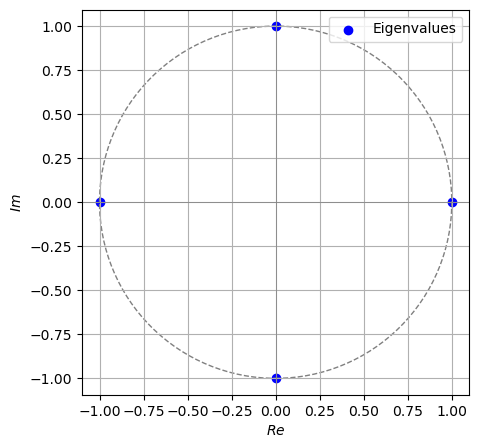

State 0: return times = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]... GCD = 4
State 1: return times = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]... GCD = 4
State 2: return times = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]... GCD = 4
State 3: return times = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]... GCD = 4

Overall chain period: 4
The chain is periodic with period 4


In [84]:
# Define the transition matrix T
from fractions import Fraction

T = np.array([
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]
])

# 1. Eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(T)

for i, vec in enumerate(eigvecs.T):  # T for transpose: columns become rows
    print(f"\nEigenvalue {eigvals[i]:.4f}")
    print("Vector:", np.round(vec, 4))
    

# 2. Plot spectrum in complex plane
plt.figure(figsize=(5,5))
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.scatter(eigvals.real, eigvals.imag, color='blue', label='Eigenvalues')
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.xlabel("$Re$")
plt.ylabel("$Im$")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

test_aperiodicity(T)

In [85]:
# 3. Check T^4 == Identity
T4 = np.linalg.matrix_power(T, 4)
print("\nT^4:")
print(np.round(T4))  # rounding to remove floating point errors

# 4. Check T^k for large k
k = 50
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))

# 4. Check T^k for large k
k = 110
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))



T^4:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]

T^50:
[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]

T^110:
[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]


##### b) Aperiodic, non-equilibrium Markov chain

The strict periodicity is broken by introducing some randomness into the Markov chain. This
modifies the spectrum in such a way that the eigenvalue 1 is the only one with modulus 1, all
other eigenvalues are inside the unit disk. Correspondingly, there is a gap between the
eigenvalue 1 and all other eigenvalues and the spectrum is no longer invariant under
rotations, restoring exponential convergence to the stationary distribution.


Eigenvalue 1.0000+0.0000j
Vector: [0.6255+0.j 0.2085+0.j 0.417 +0.j 0.6255+0.j]

Eigenvalue -0.7181+0.0000j
Vector: [ 0.7529+0.j -0.3495+0.j  0.1372+0.j -0.5406+0.j]

Eigenvalue -0.1410+0.6666j
Vector: [-0.6575+0.j      0.0666+0.3147j  0.4983+0.1236j  0.0927-0.4383j]

Eigenvalue -0.1410-0.6666j
Vector: [-0.6575-0.j      0.0666-0.3147j  0.4983-0.1236j  0.0927+0.4383j]

 Stationary distribution π (normalized):
1/3
1/9
2/9
1/3


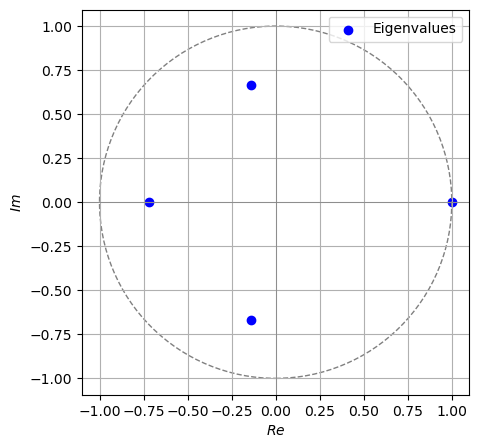

In [98]:
T = np.array([
    [0,   0,   0,   1],
    [1/3, 0,   0,   0],
    [1/3, 1,   0,   0],
    [1/3, 0,   1,   0]
])

# 1. Eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(T)
for i, vec in enumerate(eigvecs.T):  # T for transpose: columns become rows
    print(f"\nEigenvalue {eigvals[i]:.4f}")
    print("Vector:", np.round(vec, 4))

stationary_index = np.argmin(np.abs(eigvals - 1))
pi = np.real(eigvecs[:, stationary_index])
pi /= np.sum(pi)
print("\n Stationary distribution π (normalized):")
from fractions import Fraction
# Convert to fractions
pi_frac = [Fraction(val).limit_denominator() for val in pi]

for val in pi_frac:
    print(val)

# 2. Plot the spectrum in the complex plane
plt.figure(figsize=(5,5))
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.scatter(eigvals.real, eigvals.imag, color='blue', label='Eigenvalues')
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.xlabel("$Re$")
plt.ylabel("$Im$")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [100]:
test_aperiodicity(T)

# 4. Check T^4 
T4 = np.linalg.matrix_power(T, 4)
print("\nT^4:")
print(np.round(T4))  # rounding to remove floating point errors

# 4. Check T^k for large k
k = 10
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))


# 4. Check T^k for large k
k = 49
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))

# 4. Check T^k for large k
k = 50
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))


# 4. Check T^k for large k
k = 55
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))


# 4. Check T^k for large k
k = 65
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))

State 0: return times = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]... GCD = 1
State 1: return times = [4, 6, 7, 8, 9, 10, 11, 12, 13, 14]... GCD = 1
State 2: return times = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]... GCD = 1
State 3: return times = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]... GCD = 1

Overall chain period: 1
 The chain is aperiodic.

T^4:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

T^10:
[[0.3498 0.3333 0.3457 0.3086]
 [0.1029 0.1235 0.1111 0.1152]
 [0.2181 0.1975 0.2346 0.2263]
 [0.3292 0.3457 0.3086 0.3498]]

T^49:
[[0.3333 0.3333 0.3333 0.3333]
 [0.1111 0.1111 0.1111 0.1111]
 [0.2222 0.2222 0.2222 0.2222]
 [0.3333 0.3333 0.3333 0.3333]]

T^50:
[[0.3333 0.3333 0.3333 0.3333]
 [0.1111 0.1111 0.1111 0.1111]
 [0.2222 0.2222 0.2222 0.2222]
 [0.3333 0.3333 0.3333 0.3333]]

T^55:
[[0.3333 0.3333 0.3333 0.3333]
 [0.1111 0.1111 0.1111 0.1111]
 [0.2222 0.2222 0.2222 0.2222]
 [0.3333 0.3333 0.3333 0.3333]]

T^65:
[[0.3333 0.3333 0.3333 0.3333]
 [0.1111 0.1111 0.1111 0.1111]
 [0.2222 0

In [104]:
print("\nDetailed balance check (π[i] * T[i,j] vs π[j] * T[j,i]):")
violated = False
# Convert to fractions for exact comparison
pi_frac = [Fraction(p).limit_denominator() for p in pi]
T_frac = np.array([[Fraction(val).limit_denominator() for val in row] for row in T])

print("Stationary distribution π (fractions):")
for i, val in enumerate(pi_frac):
    print(f"π[{i}] = {val}")
for i in range(4):
    for j in range(4):
        left = pi_frac[i] * T_frac[i][j]
        right = pi_frac[j] * T_frac[j][i]
        if left != right:
            print(f"Violation at (i={i}, j={j}): π[{i}]*T[{i},{j}] = {left} ≠ π[{j}]*T[{j},{i}] = {right}")
            violated = True

if not violated:
    print("Detailed balance holds for all (i, j).")
else:
    print("\nthe system is NOT in equilibrium.")


Detailed balance check (π[i] * T[i,j] vs π[j] * T[j,i]):
Stationary distribution π (fractions):
π[0] = 1/3
π[1] = 1/9
π[2] = 2/9
π[3] = 1/3
Violation at (i=0, j=1): π[0]*T[0,1] = 0 ≠ π[1]*T[1,0] = 1/27
Violation at (i=0, j=2): π[0]*T[0,2] = 0 ≠ π[2]*T[2,0] = 2/27
Violation at (i=0, j=3): π[0]*T[0,3] = 1/3 ≠ π[3]*T[3,0] = 1/9
Violation at (i=1, j=0): π[1]*T[1,0] = 1/27 ≠ π[0]*T[0,1] = 0
Violation at (i=1, j=2): π[1]*T[1,2] = 0 ≠ π[2]*T[2,1] = 2/9
Violation at (i=2, j=0): π[2]*T[2,0] = 2/27 ≠ π[0]*T[0,2] = 0
Violation at (i=2, j=1): π[2]*T[2,1] = 2/9 ≠ π[1]*T[1,2] = 0
Violation at (i=2, j=3): π[2]*T[2,3] = 0 ≠ π[3]*T[3,2] = 1/3
Violation at (i=3, j=0): π[3]*T[3,0] = 1/9 ≠ π[0]*T[0,3] = 1/3
Violation at (i=3, j=2): π[3]*T[3,2] = 1/3 ≠ π[2]*T[2,3] = 0

the system is NOT in equilibrium.


##### c) Asymptotically periodic Markov chain

the spectrum is invariant under rotations by 180° and the Markov chain is periodic for long times.


Eigenvalue -1.0000+0.0000j
Vector: [-0.6325+0.j  0.3162+0.j -0.3162+0.j  0.6325+0.j]

Eigenvalue 1.0000+0.0000j
Vector: [0.6325+0.j 0.3162+0.j 0.3162+0.j 0.6325+0.j]

Eigenvalue 0.0000+0.7071j
Vector: [ 0.5774+0.j      0.    -0.4082j -0.5774+0.j      0.    +0.4082j]

Eigenvalue 0.0000-0.7071j
Vector: [ 0.5774-0.j      0.    +0.4082j -0.5774-0.j      0.    -0.4082j]

 Stationary distribution π (normalized):
1/3
1/6
1/6
1/3


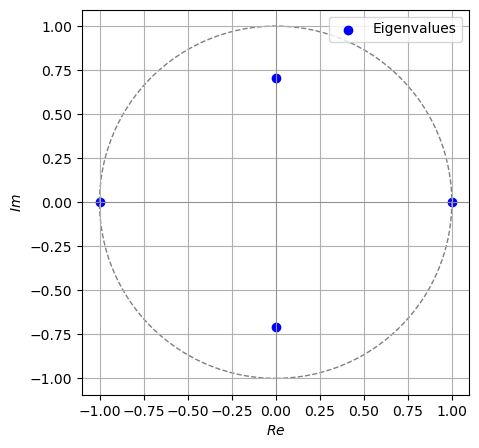

In [106]:
T = np.array([
    [0,   0,   0,   1],
    [0.5, 0,   0,   0],
    [0,   1,   0,   0],
    [0.5, 0,   1,   0]
])

# 1. Eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(T)
for i, vec in enumerate(eigvecs.T):  # T for transpose: columns become rows
    print(f"\nEigenvalue {eigvals[i]:.4f}")
    print("Vector:", np.round(vec, 4))

stationary_index = np.argmin(np.abs(eigvals - 1))
pi = np.real(eigvecs[:, stationary_index])
pi /= np.sum(pi)
print("\n Stationary distribution π (normalized):")
from fractions import Fraction
# Convert to fractions
pi_frac = [Fraction(val).limit_denominator() for val in pi]

for val in pi_frac:
    print(val)

# 2. Plot the spectrum in the complex plane
plt.figure(figsize=(5,5))
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.scatter(eigvals.real, eigvals.imag, color='blue', label='Eigenvalues')
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.xlabel("$Re$")
plt.ylabel("$Im$")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [109]:
test_aperiodicity(T)


# 4. Check T^k for large k
k = 49
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))

# 4. Check T^k for large k
k = 50
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))


# 4. Check T^k for large k
k = 51
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))


# 4. Check T^k for large k
k = 65
Tk = np.linalg.matrix_power(T, k)
print(f"\nT^{k}:")
print(np.round(Tk, 4))

State 0: return times = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]... GCD = 2
State 1: return times = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]... GCD = 2
State 2: return times = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]... GCD = 2
State 3: return times = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]... GCD = 2

Overall chain period: 2
The chain is periodic with period 2

T^49:
[[0.     0.6667 0.     0.6667]
 [0.3333 0.     0.3333 0.    ]
 [0.     0.3333 0.     0.3333]
 [0.6667 0.     0.6667 0.    ]]

T^50:
[[0.6667 0.     0.6667 0.    ]
 [0.     0.3333 0.     0.3333]
 [0.3333 0.     0.3333 0.    ]
 [0.     0.6667 0.     0.6667]]

T^51:
[[0.     0.6667 0.     0.6667]
 [0.3333 0.     0.3333 0.    ]
 [0.     0.3333 0.     0.3333]
 [0.6667 0.     0.6667 0.    ]]

T^65:
[[0.     0.6667 0.     0.6667]
 [0.3333 0.     0.3333 0.    ]
 [0.     0.3333 0.     0.3333]
 [0.6667 0.     0.6667 0.    ]]


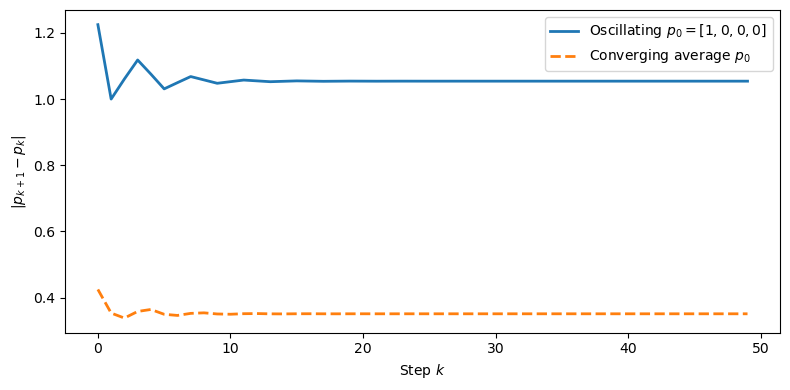

In [111]:
def run_chain(p0, steps=50):
    p = p0.copy()
    history = [p]
    diffs = []
    for _ in range(steps):
        p_next = T @ p
        diffs.append(np.linalg.norm(p_next - p))
        p = p_next
        history.append(p)
    return np.array(history), diffs

# Initial distributions
p0_oscillating = np.array([1, 0, 0, 0])  # Starts in state 0
p0_converging = 0.5 * np.array([1/3, 1/3, 1/3, 0]) + 0.5 * np.array([0, 0, 0, 1])  # Averaged

# Run
history_osc, diffs_osc = run_chain(p0_oscillating, steps=50)
history_conv, diffs_conv = run_chain(p0_converging, steps=50)

# Plot difference norms
plt.figure(figsize=(8, 4))
plt.plot(diffs_osc, label='Oscillating $p_0 = [1,0,0,0]$', lw=2)
plt.plot(diffs_conv, label='Converging average $p_0$', lw=2, linestyle='--')
plt.xlabel("Step $k$")
plt.ylabel("$\\|p_{k+1} - p_k\\|$")
plt.legend()
plt.tight_layout()
plt.show()
